## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

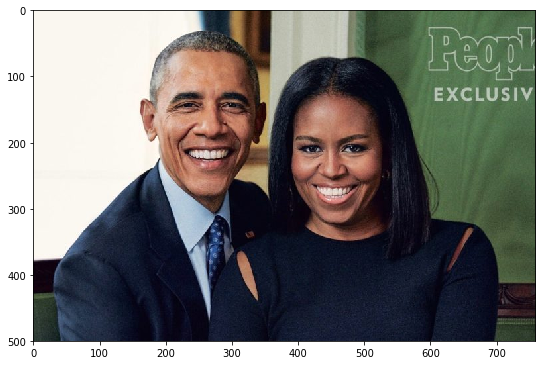

In [9]:
import cv2
# load in color image for face detection
# image = cv2.imread('images/obamas.jpg')

image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


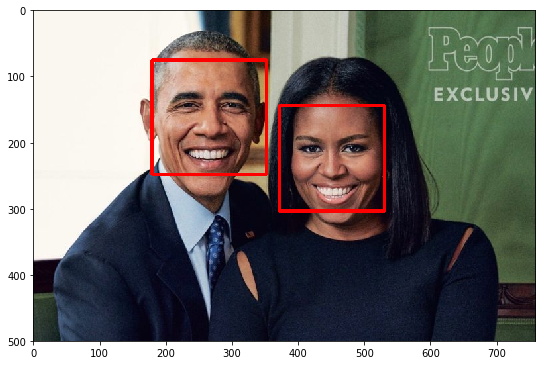

In [10]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [11]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I
from models import Net

filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)

class Net(nn.Module):

    def __init__(self,weight):
        super(Net, self).__init__()
        k_height, k_width = weight.shape[2:]
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(k_height, k_width),bias=False)
        self.conv1.weight = torch.nn.Parameter(weight)
        self.conv2 = nn.Conv2d(4, 512, kernel_size=(k_height, k_width) )
        self.conv3 = nn.Conv2d(512, 1026 ,kernel_size=(k_height, k_width))
        self.pool = nn.MaxPool2d(4,4)
        
        self.fc1 = nn.Linear(4104,512)
        self.fc1_drop = nn.Dropout(p=0.4)
        self.fcfinal = nn.Linear(512, 136)
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = (x.view(x.size(0),-1))
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fcfinal(x)
        
        
        # a modified x, having gone through all the layers of your model, should be returned
        return x

net = Net(weight)

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load(r'C:\Users\IAI\Documents\i_cnn_facial_keypoints\P1_Facial_Keypoints\saved_models\MSE_SGD_30_4x512x1096.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (conv2): Conv2d(4, 512, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(512, 1026, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4104, out_features=512, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fcfinal): Linear(in_features=512, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




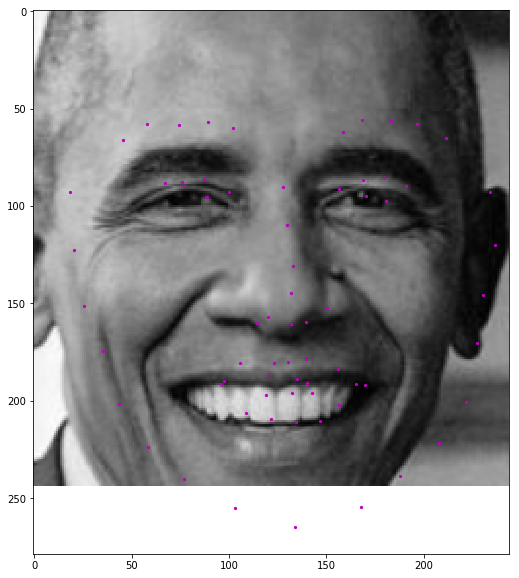

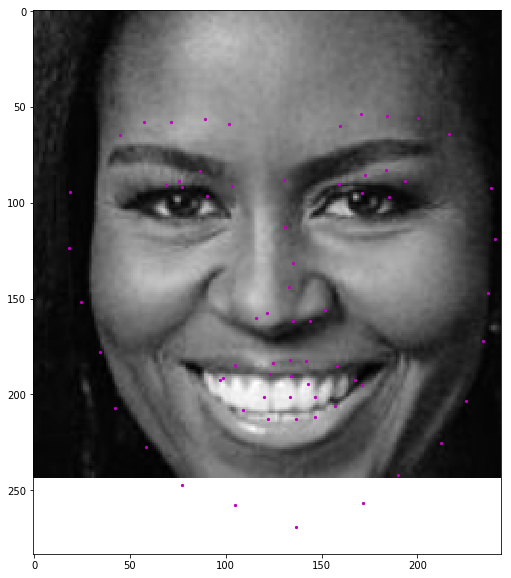

In [13]:
from data_load import Rescale, RandomCrop, Normalize, ToTensor
image_copy = np.copy(image)

def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[0][:, 0], predicted_key_pts[0][:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
        
# loop over the detected faces from your haar cascade

for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    
    ## TODO: Convert the face region from RGB to grayscale
    
    gray_image1 = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    
    gray_image = gray_image1.astype("float32")/255
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    
    h, w = gray_image.shape[:2]
    new_h, new_w = int(244), int(244 * w / h)
    resized_img = cv2.resize(gray_image, (new_w, new_h))
    
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    
    reshaped_img = resized_img.reshape(resized_img.shape[0], resized_img.shape[1], 1)
    
    reshaped_img = torch.from_numpy(reshaped_img.transpose((2, 0, 1)))

    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 

    outputs_pts = net(reshaped_img.unsqueeze_(0) )
    outputs = outputs_pts.view(outputs_pts.size()[0], 68, -1)
    
    ## TODO: Display each detected face and the corresponding keypoints        
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1, 1, 1)

 
    # un-transform the predicted key_pts data
    
    predicted_key_pts = outputs.data
    predicted_key_pts = predicted_key_pts.numpy()
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*110+100
    show_all_keypoints(cv2.resize(gray_image1, (int(244), int(244))), predicted_key_pts, None)

